In [1]:
import sys

sys.path.append("..")

In [2]:
!pip install optuna

In [2]:
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn import svm, ensemble
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD
import optuna
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

In [13]:
df = pd.read_pickle("../bigdata2023classification/preprocessed_train_df.pkl")  

In [15]:
# df = df.head(5000)

In [14]:
for label in df['Label'].unique():
    print(f"Total rows of {label} are {df[df['Label']==label]['Id'].count()}")

Total rows of Entertainment are 44834
Total rows of Technology are 30107
Total rows of Business are 24834
Total rows of Health are 12020


## Data Analysis 🔍

In [7]:
def generate_word_cloud(words, label):
    word_cloud = WordCloud(width=800, height=400, background_color='black').generate(words)
    plt.figure(figsize=(10, 5), facecolor='black', edgecolor='black')
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(label, color='white')
    plt.tight_layout(pad=0)
    plt.show()

Category: Entertainment


,Common_Word,Frequency
1,hallerne,36
2,piaseckigc,22
3,penninkinvisionap,22
4,crib,21
5,lachanze,20
6,chihuahua,18
7,lesdoggg,16
8,petrella,16
9,napa,16


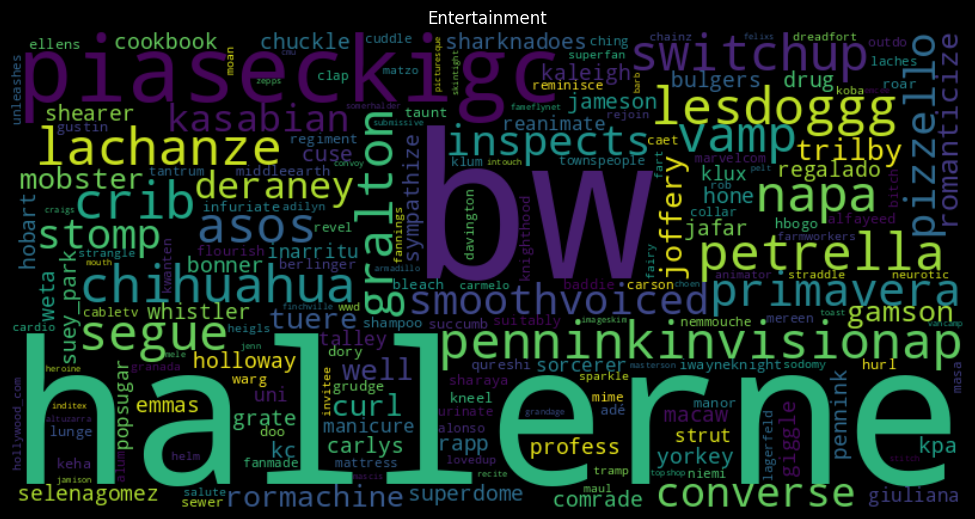

Category: Technology


,Common_Word,Frequency
1,helicoidal,23
2,oarfish,22
3,kisailus,21
4,gas,21
5,supermassive,20
6,equinix,20
7,logicalis,19
8,goz,19
9,nasagoddardpix,19


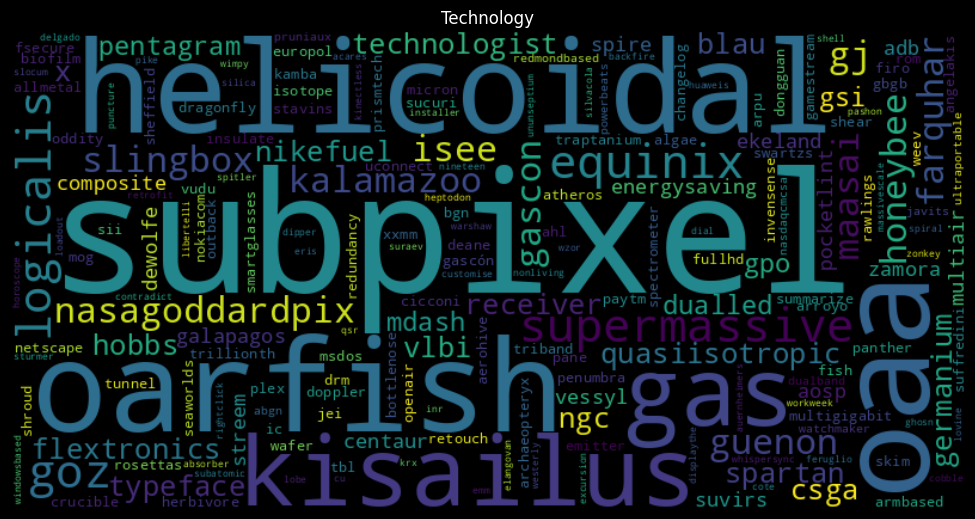

Category: Business


,Common_Word,Frequency
1,desalination,31
2,sga,27
3,waterfx,27
4,dn,25
5,viropharma,25
6,ifill,23
7,urbanization,20
8,mandell,20
9,oligarch,19


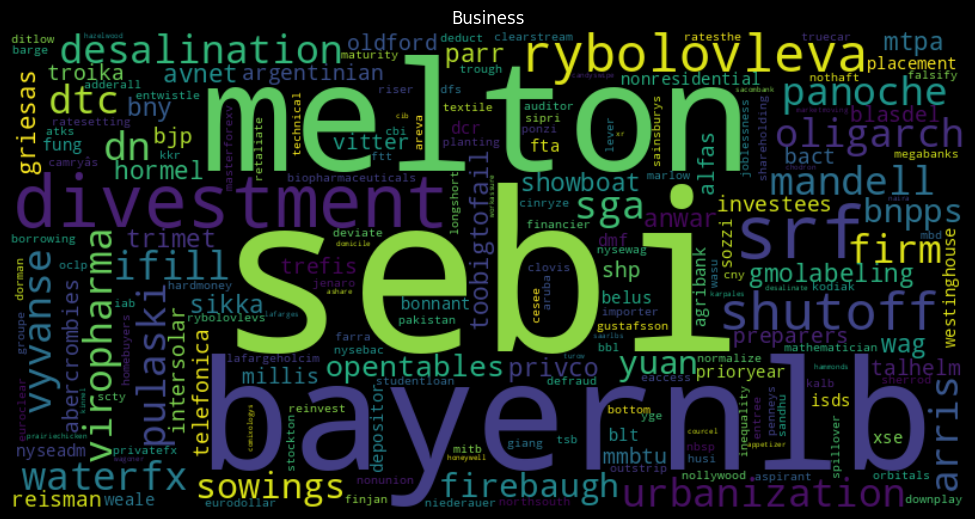

Category: Health


,Common_Word,Frequency
1,eggadapted,26
2,alzheimer,23
3,oa,23
4,prev,20
5,romneycare,18
6,ldts,18
7,ecowas,18
8,pluripotent,17
9,experimenter,16


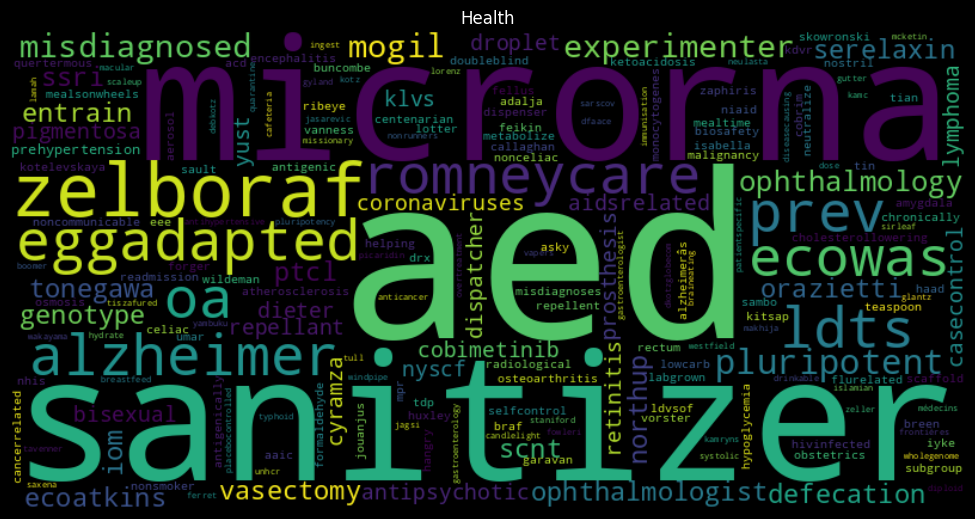

In [8]:
for label in df['Label'].unique():
    label_data = df[df['Label'] == label]
    print(f'Category: {label}')

    all_words = [word for text in label_data["Content"] for word in word_tokenize(text)]
    most_common_words = Counter(all_words).most_common(500)
    
    most_common_df = pd.DataFrame(most_common_words[:10])
    most_common_df = most_common_df.iloc[1:,:]

    most_common_df.columns = ['Common_Word','Frequency']
    display(most_common_df.style.background_gradient(cmap='Blues'))
    cloud_words = " ".join(word[0] for word in most_common_words)
    generate_word_cloud(cloud_words,label)


# Classification

We will try **Support Vector Machines (SVM)** and **Random Forests** using the features **Bag of Words (BoW)** and **SVD** to evaluate them. \
We are going to evaluate and report the performance of every model + feature combination
with 5-fold Cross Validation using:
* Accuracy
* Precision
* Recall

In order to evaluate the model performance we expirement with the hyperparameters of BoW method, SVD method, SVM model and Random Forest Model. In order to find the optimal ones we use optuna:\
A modern hyperparameter optimization framework that implements both grid search and more sophisticated algorithms like TPE (Tree-structured Parzen Estimator). It's designed for efficiency and ease of use, providing a flexible and clear interface for defining search spaces and optimization targets.

The hyperparameters we experiment with are:\
\
For **BoW**
* **max_df** and **min_df**: These control the vocabulary size. max_df filters out terms that are too common, and min_df filters out terms that are too rare. The exact best values are data-dependent.

* **ngram_range**: This determines whether you use unigrams, bigrams, or both. Including bigrams can capture some context, but also increases the feature space.

For **SVD**
* **n_components** : This parameter specifies the number of dimensions to retain after performing SVD. It essentially determines how much of the original variance in the data is preserved. A higher number of components can capture more information but may also include more noise and increase computational cost. 

For **SVM**
* **C**: This is the regularization parameter. A larger C can lead to overfitting (very high values make the decision surface more sensitive to training data), while a smaller C encourages a larger margin but can underfit.

* **gamma**: This defines the influence of a single training sample. scale and auto are commonly used options, especially for non-linear kernels.

* **kernel**: This defines the type of hyperplane used to separate the data. Different kernels can radically change the model, and the best choice is highly dependent on the nature of your data.

For **Random Forest**

* **n_estimators**: This parameter specifies the number of trees in the forest. Generally, more trees increase the model's ability to generalize but also increase computational cost. A higher number of trees can lead to better performance but diminishing returns after a certain point
* **max_depth**: This determines the maximum depth of each tree. Deeper trees can model more complex patterns but are also more prone to overfitting. It's often necessary to balance tree depth with model complexity.
* **min_samples_split**: This is the minimum number of samples required to split an internal node in a tree. Higher values prevent creating nodes that represent very specific, possibly noisy patterns, thus controlling overfitting.
* **min_samples_leaf**: This parameter defines the minimum number of samples a leaf node must have. Increasing this value can smooth the model, especially for regression, by preventing the algorithm from learning noise in the training data.

In [16]:
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro')
}

y = df['Label']

## SVM with BoW

Expirement with hyperparameters for SVM model with bow

In [ ]:
# Expirement with hyperparameters for SVM model with bow
def objective(trial):
    max_df = trial.suggest_float('max_df', 0.5, 1.0)
    min_df = trial.suggest_int('min_df', 1, 5)          
    ngram_1 = trial.suggest_categorical('ngram_1', [1, 1])
    ngram_2 = trial.suggest_categorical('ngram_2', [1, 2])
    ngram_range = (ngram_1, ngram_2)
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])

    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)
    X_bow = vectorizer.fit_transform(df['Content'])

    model = svm.SVC(C=C, gamma=gamma, kernel=kernel)

    score = cross_val_score(model, X_bow, y, n_jobs=-1, cv=3).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
print("Best parameters for BoW with SVM:", best_params)


Evaluate Model with best hyperparameters

In [ ]:
max_df = best_params['max_df']
min_df = best_params['min_df']
ngram_1 = best_params['ngram_1']
ngram_2 = best_params['ngram_2']
ngram_range = (ngram_1, ngram_2)
C = best_params['C']
gamma = best_params['gamma']
kernel = best_params['kernel']
    
vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)
X_bow = vectorizer.fit_transform(df['Content'])

model = svm.SVC(C=C, gamma=gamma, kernel=kernel)
svm_results_bow = cross_validate(model, X_bow, y, cv=5, scoring=scoring_metrics)
print("SVM Model with BoW:")
for metric in scoring_metrics.keys():
    mean_score = svm_results_bow[f'test_{metric}'].mean()
    print(f"- {metric.capitalize()}: {mean_score:.2f}")
print("\n")

## SVM with BoW and SVD

Expirement with hyperparameters for SVM model with SVD

In [ ]:
# Expirement with hyperparameters for SVM model with bow
def objective(trial):
    max_df = trial.suggest_float('max_df', 0.5, 1.0)
    min_df = trial.suggest_int('min_df', 1, 5)          
    ngram_1 = trial.suggest_categorical('ngram_1', [1, 1])
    ngram_2 = trial.suggest_categorical('ngram_2', [1, 2])
    ngram_range = (ngram_1, ngram_2)
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    n_components = trial.suggest_int('n_components', 50, 300)

    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)
    X_bow = vectorizer.fit_transform(df['Content'])

    svd = TruncatedSVD(n_components=n_components)
    X_svd = svd.fit_transform(X_bow)

    model = svm.SVC(C=C, gamma=gamma, kernel=kernel)

    score = cross_val_score(model, X_svd, y, n_jobs=-1, cv=3).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
print("Best parameters for SVD with SVM:", best_params)


Evaluate Model with best hyperparameters

In [ ]:
max_df = best_params['max_df']
min_df = best_params['min_df']
ngram_1 = best_params['ngram_1']
ngram_2 = best_params['ngram_2']
ngram_range = (ngram_1, ngram_2)
C = best_params['C']
gamma = best_params['gamma']
kernel = best_params['kernel']
n_components = best_params['n_components']

vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)
X_bow = vectorizer.fit_transform(df['Content'])

svd = TruncatedSVD(n_components=n_components)
X_svd = svd.fit_transform(X_bow)

model = svm.SVC(C=C, gamma=gamma, kernel=kernel)
svm_results_svd = cross_validate(model, X_svd, y, cv=5, scoring=scoring_metrics)
print("SVM Model with SVD:")
for metric in scoring_metrics.keys():
    mean_score = svm_results_svd[f'test_{metric}'].mean()
    print(f"- {metric.capitalize()}: {mean_score:.2f}")
print("\n")

## Random Forest with BoW

Expirement with hyperparameters for Random Forest model with bow

In [ ]:
def objective(trial):
    max_df = trial.suggest_float('max_df', 0.5, 1.0)
    min_df = trial.suggest_int('min_df', 1, 5)
    ngram_1 = trial.suggest_categorical('ngram_1', [1, 1])
    ngram_2 = trial.suggest_categorical('ngram_2', [1, 2])
    ngram_range = (ngram_1, ngram_2)

    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)
    X_bow = vectorizer.fit_transform(df['Content'])

    model = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                   min_samples_split=min_samples_split, 
                                   min_samples_leaf=min_samples_leaf)
    score = cross_val_score(model, X_bow, y, n_jobs=-1, cv=5).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
best_params = study.best_params

print("Best parameters for BoW with Random Forest:", best_params)


Evaluate Model with best hyperparameters

In [15]:
max_df = best_params['max_df']
min_df = best_params['min_df']
ngram_1 = best_params['ngram_1']
ngram_2 = best_params['ngram_2']
ngram_range = (ngram_1, ngram_2)
n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']
min_samples_split = best_params['min_samples_split']
min_samples_leaf = best_params['min_samples_leaf']

vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)
X_bow = vectorizer.fit_transform(df['Content'])

model = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                   min_samples_split=min_samples_split, 
                                   min_samples_leaf=min_samples_leaf)
rf_results_bow = cross_validate(model, X_bow, y, cv=5, scoring=scoring_metrics)
print("Random Forest Model with BoW:")
for metric in scoring_metrics.keys():
    mean_score = rf_results_bow[f'test_{metric}'].mean()
    print(f"- {metric.capitalize()}: {mean_score:.2f}")
print("\n")

Random Forest Model with BoW:
- Accuracy: 0.43
- Precision: 0.74
- Recall: 0.30




## Random Forest with SVD

Expirement with hyperparameters for Random Forest model with bow

In [ ]:
def objective(trial):
    # CountVectorizer hyperparameters
    max_df = trial.suggest_float('max_df', 0.5, 1.0)
    min_df = trial.suggest_int('min_df', 1, 5)
    ngram_1 = trial.suggest_categorical('ngram_1', [1, 1])
    ngram_2 = trial.suggest_categorical('ngram_2', [1, 2])
    ngram_range = (ngram_1, ngram_2)

    # SVD hyperparameters
    n_components = trial.suggest_int('n_components', 50, 300)

    # Random Forest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)
    X_bow = vectorizer.fit_transform(df['Content'])

    svd = TruncatedSVD(n_components=n_components)
    X_svd = svd.fit_transform(X_bow)

    model = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                   min_samples_split=min_samples_split, 
                                   min_samples_leaf=min_samples_leaf)
    score = cross_val_score(model, X_svd, y, n_jobs=-1, cv=5).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
best_params = study.best_params

print("Best parameters for SVD with Random Forest:", best_params)


Evaluate Model with best hyperparameters

In [ ]:
max_df = best_params['max_df']
min_df = best_params['min_df']
ngram_1 = best_params['ngram_1']
ngram_2 = best_params['ngram_2']
ngram_range = (ngram_1, ngram_2)
n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']
min_samples_split = best_params['min_samples_split']
min_samples_leaf = best_params['min_samples_leaf']
n_components = best_params['n_components']

vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)
X_bow = vectorizer.fit_transform(df['Content'])

svd = TruncatedSVD(n_components=n_components)
X_svd = svd.fit_transform(X_bow)

model = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                   min_samples_split=min_samples_split, 
                                   min_samples_leaf=min_samples_leaf)
rf_results_svd = cross_validate(model, X_svd, y, cv=5, scoring=scoring_metrics)
print("Random Forest Model with BoW:")
for metric in scoring_metrics.keys():
    mean_score = rf_results_svd[f'test_{metric}'].mean()
    print(f"- {metric.capitalize()}: {mean_score:.2f}")
print("\n")

## Beat the Benchmark

We are going to include the title column along with the content column as feature for the prediction giving bigger weight in title as it includes representing info

Experiment with combination of hyperparamters and combination of methods too with combined title and content as features:
1. svm with bow
2. svm with svd
3. rf with bow
4. rf with svd

In [ ]:
def objective(trial):
    vectorization = trial.suggest_categorical('vectorization', ['BoW', 'SVD'])
    model_name = trial.suggest_categorical('model_name', ['SVM', 'RF'])

    max_df = trial.suggest_float('max_df', 0.5, 1.0)
    min_df = trial.suggest_int('min_df', 1, 5)          
    ngram_1 = trial.suggest_categorical('ngram_1', [1, 1])
    ngram_2 = trial.suggest_categorical('ngram_2', [1, 2])
    ngram_range = (ngram_1, ngram_2)
    title_weight_factor = trial.suggest_float('title_weight_factor', 2, 10)

    vectorizer_content  = CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)
    vectorizer_title  = CountVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)

    bow_title = vectorizer_title.fit_transform(df['Title']) 
    bow_content = vectorizer_content.fit_transform(df['Content'])

    weighted_bow_title = bow_title.multiply(title_weight_factor)

    X = hstack([weighted_bow_title, bow_content])

    if vectorization == 'SVD':
        n_components = trial.suggest_int('n_components', 50, 300)
        svd = TruncatedSVD(n_components=n_components)
        X = svd.fit_transform(X)

    class_weight = trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None])

    if model_name == 'SVM':
        C = trial.suggest_float('C', 1e-3, 1e3, log=True)
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        if kernel == 'linear':
            penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
            model = svm.LinearSVC(C=C, penalty=penalty, dual=False, class_weight=class_weight)
        else:
            model = svm.SVC(C=C, gamma=gamma, kernel=kernel, class_weight=class_weight)
    else:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        model = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                       max_features=max_features, class_weight=class_weight)
    score = cross_val_score(model, X, y, n_jobs=-1, cv=3).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

best_params = study.best_params
print("Best parameters:", best_params)


Display best 20 trials hyperparamters values, score and duration

In [ ]:
trials_df = study.trials_dataframe()
trials_df = trials_df.drop(['state', 'datetime_start', 'datetime_complete'], axis=1)
trials_df['duration'] = trials_df['duration'].dt.total_seconds() / 60
trials_df.rename(columns={'duration': 'duration (minutes)'}, inplace=True)
sorted_trials_df = trials_df.sort_values(by='value', ascending=False)
display(sorted_trials_df.head(20))

## Compare Results

In [ ]:
def mean_score(results, metric):
    return results[f'test_{metric}'].mean()

metrics = ['accuracy', 'precision', 'recall']

data = {
    'Statistic Measure': ['Accuracy', 'Precision', 'Recall'],
    'SVM (BoW)': [mean_score(svm_results_bow, metric) for metric in metrics],
    'Random Forest (BoW)': [mean_score(rf_results_bow, metric) for metric in metrics],
    'SVM (SVD)': [mean_score(svm_results_svd, metric) for metric in metrics],
    'Random Forest (SVD)': [mean_score(rf_results_svd, metric) for metric in metrics],
    'My Method': [None,None,None]
}

comparison_table = pd.DataFrame(data)

display(comparison_table)

,Statistic Measure,SVM (BoW),Random Forest (BoW),SVM (SVD),Random Forest (SVD),My Method
0,Accuracy,0.762000,0.747000,0.769000,0.804000,None
1,Precision,0.772166,0.810658,0.778480,0.810997,None
2,Recall,0.711631,0.665012,0.718385,0.747637,None


## Predict labels on test dataset

Preprocess test dataset

In [ ]:
# test_df = pd.read_pickle("../bigdata2023classification/preprocessed_test_df.pkl")  

Text Transformation

In [ ]:
# vectorizer = CountVectorizer(max_df=best_params['max_df'], 
#                              min_df=best_params['min_df'], 
#                              ngram_range=best_params['ngram_range'])
# X_bow = vectorizer.fit_transform(df['Content'])

# svd = TruncatedSVD(n_components=best_params['n_components'])
# X_svd = svd.fit_transform(X_bow)

Fit the model

In [ ]:
# rf_model = ensemble.RandomForestClassifier(n_estimators=best_params['n_estimators'], 
#                                   max_depth=best_params['max_depth'], 
#                                   min_samples_split=best_params['min_samples_split'], 
#                                   min_samples_leaf=best_params['min_samples_leaf'])
# rf_model.fit(X_svd, y)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=7,
                       n_estimators=686)

Predict labels and write the results in a csv file

In [ ]:
# X_bow_test = vectorizer.transform(test_df['Content'])  
# X_svd_test = svd.transform(X_bow_test)

# predicted_labels = rf_model.predict(X_svd_test)

# output_df = pd.DataFrame({'Id': test_df['Id'], 'Predicted': predicted_labels})

# # output_df.to_csv('../results/predicted_labels.csv', index=False)
